In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import wandb
import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(project_root)

from models.cnn.cnn import CNNModel

from performance_measures.metrics import Metrics
from models.MLP.MLP import MLP_Classifier
from performance_measures import metrics as metrics1
from models.MLP.MLP import MLP_Regression
from models.AutoEncoders.AutoEncoders import AutoEncoder
from models.knn.knn import KNN


# 2.1

In [4]:
def load_mnist_data(root_dir):

    data = {'train': [], 'val': [], 'test': []}
    
    # Loop over the splits (train, val, test)
    for split in data.keys():
        split_dir = os.path.join(root_dir, split)
        
        # Loop over each folder in the split directory (e.g., 1, 2, 123, etc.)
        for label_folder in os.listdir(split_dir):
            label_dir = os.path.join(split_dir, label_folder)
            
            # Only process if it's a directory
            if not os.path.isdir(label_dir):
                continue
            
            # If the folder name is '0', assign the label as 0
            if label_folder == '0':
                label = 0
            else:
                # Label is the number of digits in the folder name
                if label_folder.isdigit():
                    label = len(label_folder)
                else:
                    label = 0
            
            # Loop over each image file in the label folder
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale mode
                if image is not None:
                    data[split].append((image, label))
    
    return data

# Path to the dataset
dir_path1 = '../../data/interim/4/double_mnist'
data = load_mnist_data(dir_path1)

# Check the loaded data structure
print(f"Number of training samples: {len(data['train'])}")
print(f"Number of validation samples: {len(data['val'])}")
print(f"Number of test samples: {len(data['test'])}")


# class inherits from torch.utils.data.Dataset
class MultiMNISTDataset(Dataset):
    
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get the image and label at index `idx`
        image, label = self.data[idx]
        
        # Convert the image to a format compatible with PyTorch transformations
        image = np.expand_dims(image, axis=2)  # Add channel dimension for grayscale
        image = transforms.ToTensor()(image)  # Convert to Tensor
        
        # Apply transformations, if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations
transform = transforms.Normalize((0.5,), (0.5,))  # Normalization for grayscale

# Create Dataset and DataLoader instances for each split
train_dataset = MultiMNISTDataset(data['train'], transform=transform)
val_dataset = MultiMNISTDataset(data['val'], transform=transform)
test_dataset = MultiMNISTDataset(data['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check sample batch
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels}")
    break

unique_labels = set(label for _, label in data['train'])  # Extract unique labels from the training data
print(f"Number of unique labels: {len(unique_labels)}, Unique labels: {unique_labels}")


Number of training samples: 12600
Number of validation samples: 3000
Number of test samples: 4600
Batch of images shape: torch.Size([32, 1, 128, 128])
Batch of labels: tensor([0, 3, 2, 2, 3, 3, 2, 3, 3, 2, 2, 1, 1, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 1,
        1, 2, 2, 1, 2, 3, 2, 1])
Number of unique labels: 4, Unique labels: {0, 1, 2, 3}


In [3]:
# For classification
classification_model = CNNModel(task="classification")

# For regression
regression_model = CNNModel(task="regression")

# Example input tensor
input_data = torch.randn(32, 1, 128, 128)  # batch_size of 32, 1 channel, 128x128 image

# Forward pass for classification
classification_output = classification_model(input_data)
print("Classification output shape:", classification_output.shape)  

# Forward pass for regression
regression_output = regression_model(input_data)
print("Regression output shape:", regression_output.shape)


Classification output shape: torch.Size([32, 4])
Regression output shape: torch.Size([32, 1])


2.2(in models folder)

# 2.3 

Epoch [1/10], Training Loss: 1.3474, Validation Loss: 1.1018
Epoch [2/10], Training Loss: 1.1440, Validation Loss: 1.1037
Epoch [3/10], Training Loss: 1.1439, Validation Loss: 1.1046
Epoch [4/10], Training Loss: 1.1427, Validation Loss: 1.1072
Epoch [5/10], Training Loss: 1.1420, Validation Loss: 1.1047
Epoch [6/10], Training Loss: 1.1421, Validation Loss: 1.1041
Epoch [7/10], Training Loss: 1.1420, Validation Loss: 1.1031
Epoch [8/10], Training Loss: 1.1418, Validation Loss: 1.1034
Epoch [9/10], Training Loss: 1.1420, Validation Loss: 1.1053
Epoch [10/10], Training Loss: 1.1419, Validation Loss: 1.1043
Hyperparameter Combination 1:
Training Loss: 1.1419
Validation Loss: 1.1043, Validation Accuracy: 0.5333
Best model saved!
Epoch [1/10], Training Loss: 2.5253, Validation Loss: 0.1389
Epoch [2/10], Training Loss: 0.1866, Validation Loss: 0.0608
Epoch [3/10], Training Loss: 0.1536, Validation Loss: 0.0303
Epoch [4/10], Training Loss: 0.1908, Validation Loss: 0.0948
Epoch [5/10], Training

/var/folders/9s/y0c_yj6d7c1fm05rdc4dnn7c0000gn/T/ipykernel_11173/353707495.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_m

Best Model - Validation Accuracy: 0.9987, Validation Loss: 0.0038
Best Model - Test Accuracy: 0.9993, Test Loss: 0.0023


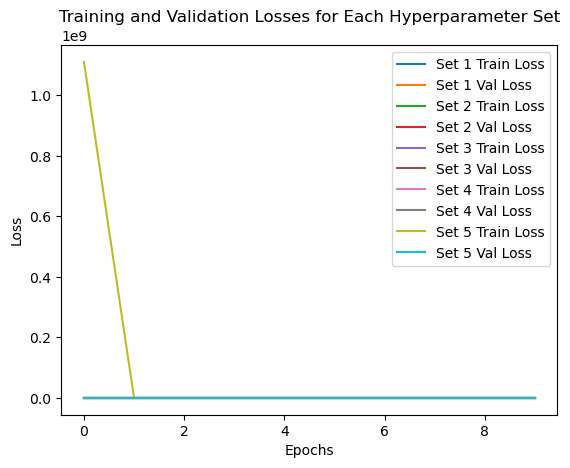

In [161]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score

def train_model(model, train_loader, val_loader, optimizer, epochs=10, task="classification"):
    criterion = nn.CrossEntropyLoss() if task == "classification" else nn.MSELoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            optimizer.zero_grad()
            if task == "regression":
                labels = labels.float().unsqueeze(1)  # Ensure labels are Float and reshaped to [batch_size, 1]
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                if task == "regression":
                    labels = labels.float().unsqueeze(1)  # Ensure validation labels match dimensions for regression
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


def calculate_accuracy(model, loader, task="classification", error_threshold=0.3):


    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    
    criterion = nn.CrossEntropyLoss() if task == "classification" else nn.MSELoss()
    
    with torch.no_grad():
        for images, labels in loader:
            if task == "regression":
                labels = labels.float().unsqueeze(1)  # Ensure labels are Float and reshaped for regression
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            if task == "classification":
                # Calculate accuracy for classification
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
            elif task == "regression":
                # Calculate accuracy for regression
                within_threshold = (torch.abs(outputs - labels) < error_threshold).sum().item()
                correct += within_threshold
                total += labels.size(0)

    # Calculate accuracy as correct / total
    accuracy = correct / total
    average_loss = total_loss / len(loader)
    return accuracy, average_loss
# Define hyperparameter sets for tuning, including task
hyperparameter_combinations = [
    {'learning_rate': 0.01, 'dropout_rate': 0.5, 'num_conv_layers': 3, 'optimizer': 'adam', 'task': 'classification'},
    {'learning_rate': 0.005, 'dropout_rate': 0.3, 'num_conv_layers': 3, 'optimizer': 'adam', 'task': 'regression'},
    {'learning_rate': 0.01, 'dropout_rate': 0.5, 'num_conv_layers': 2, 'optimizer': 'sgd', 'task': 'classification'},
    {'learning_rate': 0.005, 'dropout_rate': 0.3, 'num_conv_layers': 4, 'optimizer': 'rmsprop', 'task': 'regression'},
    {'learning_rate': 0.01, 'dropout_rate': 0.5, 'num_conv_layers': 3, 'optimizer': 'adam', 'task': 'classification'},
]
best_val_loss = float('inf')
best_model_params = None
best_model_path = "best_model.pth"

# Initialize lists to store losses
losses_classification = []  # Initialize list to store classification losses
losses_regression = []      # Initialize list to store regression losses

# Loop over hyperparameter combinations
for i, params in enumerate(hyperparameter_combinations):
    # Initialize model with specific parameters
    model = CNNModel(
        task=params['task'],
        dropout_rate=params['dropout_rate'],
        num_conv_layers=params['num_conv_layers']
    )
    
    # Define optimizer
    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9)
    elif params['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'])
    
    # Train model
    train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, epochs=10, task=params['task']) 

    # Store losses for plotting
    if params['task'] == 'classification':
        losses_classification.append((train_losses, val_losses))
    else:
        losses_regression.append((train_losses, val_losses))

    # Calculate accuracy and loss on validation set
    val_accuracy, val_loss = calculate_accuracy(model, val_loader, task=params['task'])
    
    # Print validation results
    print(f"Hyperparameter Combination {i + 1}:")
    print(f"Training Loss: {train_losses[-1]:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_params = params  # Store the best parameters
        best_model = model
        # best_model_path = f"best_model_.pth"
        torch.save(best_model.state_dict(), best_model_path)
        print("Best model saved!")

# Load the best model after training using the best configuration
best_model = CNNModel(
    task=best_model_params['task'],
    dropout_rate=best_model_params['dropout_rate'],
    num_conv_layers=best_model_params['num_conv_layers']
)
best_model.load_state_dict(torch.load(best_model_path))  # Load weights without errors

# Print best parameters
print("Best Hyperparameters:")
print(best_model_params)

# Evaluate on validation and test sets
val_accuracy, val_loss = calculate_accuracy(best_model, val_loader, task=best_model_params['task'])
test_accuracy, test_loss = calculate_accuracy(best_model, test_loader, task=best_model_params['task'])

# Print final evaluation results
print(f"Best Model - Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")
print(f"Best Model - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Plotting the losses for each set of hyperparameters
all_losses = losses_classification + losses_regression  # Combine both lists

for i, (train_losses, val_losses) in enumerate(all_losses):
    # Using a unique label for each hyperparameter set
    plt.plot(train_losses, label=f'Set {i + 1} Train Loss')
    plt.plot(val_losses, label=f'Set {i + 1} Val Loss')

plt.title('Training and Validation Losses for Each Hyperparameter Set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Hyperparameter_tuning_single_labeled.png", format="png")
plt.show()


## 2.3 Hyperparameter tuning 

### Following are the 5 combinations:

hyperparameter_combinations = [  
    {'learning_rate': 0.01, 'dropout_rate': 0.5, 'num_conv_layers': 3, 'optimizer': 'adam', 'task': 'classification'},   
    {'learning_rate': 0.005, 'dropout_rate': 0.3, 'num_conv_layers': 3, 'optimizer': 'adam', 'task': 'regression'},  
    {'learning_rate': 0.01, 'dropout_rate': 0.5, 'num_conv_layers': 2, 'optimizer': 'sgd', 'task': 'classification'},  
    {'learning_rate': 0.005, 'dropout_rate': 0.3, 'num_conv_layers': 4, 'optimizer': 'rmsprop', 'task': 'regression'},  
    {'learning_rate': 0.01, 'dropout_rate': 0.5, 'num_conv_layers': 3, 'optimizer': 'adam', 'task': 'classification'},  
]  


Epoch [1/10], Training Loss: 1.3474, Validation Loss: 1.1018  
Epoch [2/10], Training Loss: 1.1440, Validation Loss: 1.1037  
Epoch [3/10], Training Loss: 1.1439, Validation Loss: 1.1046  
Epoch [4/10], Training Loss: 1.1427, Validation Loss: 1.1072  
Epoch [5/10], Training Loss: 1.1420, Validation Loss: 1.1047  
Epoch [6/10], Training Loss: 1.1421, Validation Loss: 1.1041  
Epoch [7/10], Training Loss: 1.1420, Validation Loss: 1.1031    
Epoch [8/10], Training Loss: 1.1418, Validation Loss: 1.1034  
Epoch [9/10], Training Loss: 1.1420, Validation Loss: 1.1053  
Epoch [10/10], Training Loss: 1.1419, Validation Loss: 1.1043  

Hyperparameter Combination 1:   
Training Loss: 1.1419   
Validation Loss: 1.1043, Validation Accuracy: 0.5333  
Best model saved!   

Epoch [1/10], Training Loss: 2.5253, Validation Loss: 0.1389  
Epoch [2/10], Training Loss: 0.1866, Validation Loss: 0.0608  
Epoch [3/10], Training Loss: 0.1536, Validation Loss: 0.0303  
Epoch [4/10], Training Loss: 0.1908, Validation Loss: 0.0948  
Epoch [5/10], Training Loss: 0.1054, Validation Loss: 0.0172  
Epoch [6/10], Training Loss: 0.0746, Validation Loss: 0.0138  
Epoch [7/10], Training Loss: 0.0580, Validation Loss: 0.0118  
Epoch [8/10], Training Loss: 0.0455, Validation Loss: 0.0108  
Epoch [9/10], Training Loss: 0.0419, Validation Loss: 0.0119  
Epoch [10/10], Training Loss: 0.0381, Validation Loss: 0.0087  

Hyperparameter Combination 2:  
Training Loss: 0.0381  
Validation Loss: 0.0087, Validation Accuracy: 0.9893  
Best model saved!  
  
Epoch [1/10], Training Loss: 0.5477, Validation Loss: 0.0838  
Epoch [2/10], Training Loss: 0.1287, Validation Loss: 0.0077  
Epoch [3/10], Training Loss: 0.0659, Validation Loss: 0.0036  
Epoch [4/10], Training Loss: 0.0271, Validation Loss: 0.0007  
Epoch [5/10], Training Loss: 0.0282, Validation Loss: 0.0024  
Epoch [6/10], Training Loss: 0.0306, Validation Loss: 0.0007  
Epoch [7/10], Training Loss: 0.0213, Validation Loss: 0.0001  
Epoch [8/10], Training Loss: 0.0251, Validation Loss: 0.0008  
Epoch [9/10], Training Loss: 0.0162, Validation Loss: 0.0002  
Epoch [10/10], Training Loss: 0.0142, Validation Loss: 0.0038  
  
Hyperparameter Combination 3:  
Training Loss: 0.0142  
Validation Loss: 0.0038, Validation Accuracy: 0.9987  
Best model saved!  
  
Epoch [1/10], Training Loss: 1109594590.9948, Validation Loss: 0.0598  
Epoch [2/10], Training Loss: 0.2680, Validation Loss: 0.5413  
Epoch [3/10], Training Loss: 0.1763, Validation Loss: 0.1028  
Epoch [4/10], Training Loss: 0.1436, Validation Loss: 0.1423  
Epoch [5/10], Training Loss: 0.1771, Validation Loss: 0.0761  
Epoch [6/10], Training Loss: 0.1083, Validation Loss: 0.0155  
Epoch [7/10], Training Loss: 0.0964, Validation Loss: 0.0340  
Epoch [8/10], Training Loss: 0.1054, Validation Loss: 0.0109  
Epoch [9/10], Training Loss: 0.0477, Validation Loss: 0.0061  
Epoch [10/10], Training Loss: 0.0331, Validation Loss: 0.0045  
  
Hyperparameter Combination 4:  
Training Loss: 0.0331  
Validation Loss: 0.0045, Validation Accuracy: 0.9947  
  
Epoch [1/10], Training Loss: 0.4086, Validation Loss: 0.0144  
Epoch [2/10], Training Loss: 0.0680, Validation Loss: 0.0075  
Epoch [3/10], Training Loss: 0.0295, Validation Loss: 0.0009  
Epoch [4/10], Training Loss: 0.8435, Validation Loss: 1.9859  
Epoch [5/10], Training Loss: 1.2056, Validation Loss: 1.1043  
Epoch [6/10], Training Loss: 1.1425, Validation Loss: 1.1074  
Epoch [7/10], Training Loss: 1.1416, Validation Loss: 1.1061  
Epoch [8/10], Training Loss: 1.1418, Validation Loss: 1.1014  
Epoch [9/10], Training Loss: 1.1423, Validation Loss: 1.1043  
Epoch [10/10], Training Loss: 1.1421, Validation Loss: 1.1044  
  
Hyperparameter Combination 5:  
Training Loss: 1.1421  
Validation Loss: 1.1044, Validation Accuracy: 0.5333   



Best Hyperparameters:  
{'learning_rate': 0.01, 'dropout_rate': 0.5, 'num_conv_layers': 2, 'optimizer': 'sgd', 'task': 'classification'}  
  
Best Model - Validation Accuracy: 0.9987, Validation Loss: 0.0038  
Best Model - Test Accuracy: 0.9993, Test Loss: 0.0023  





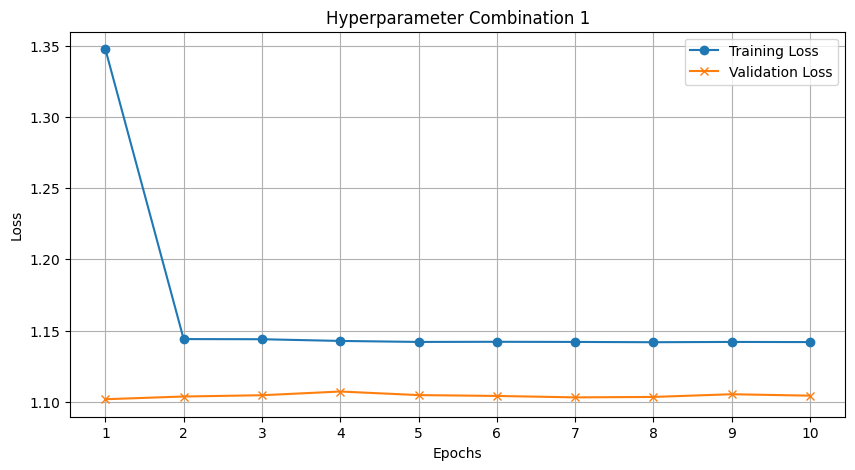

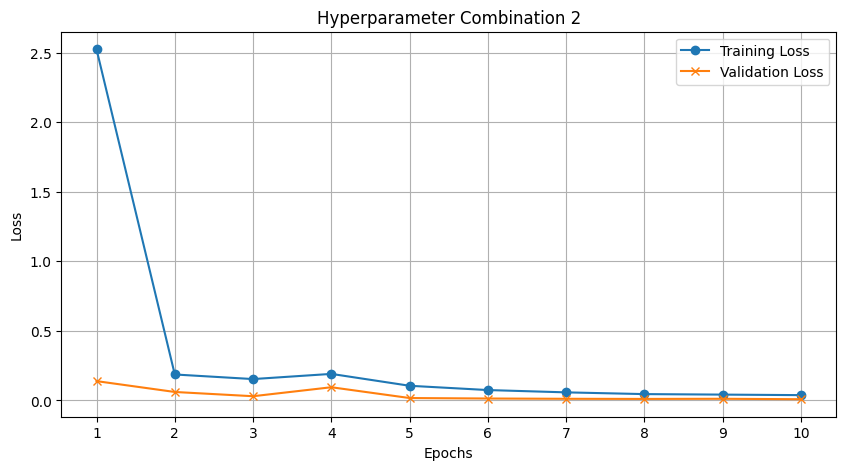

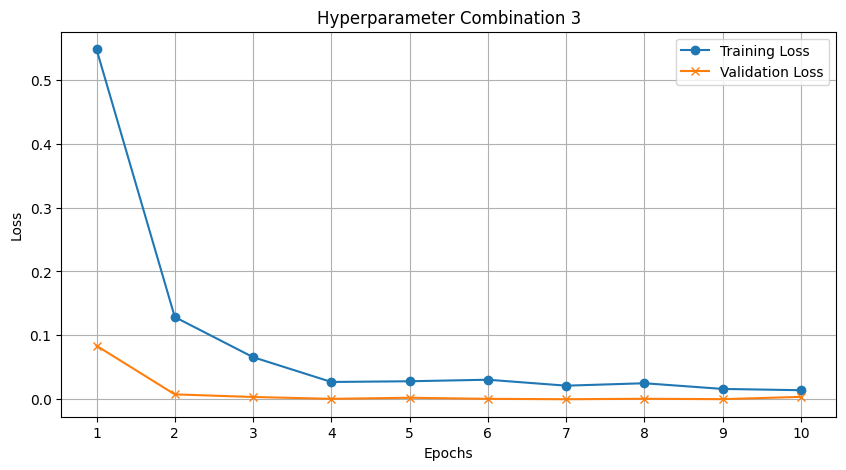

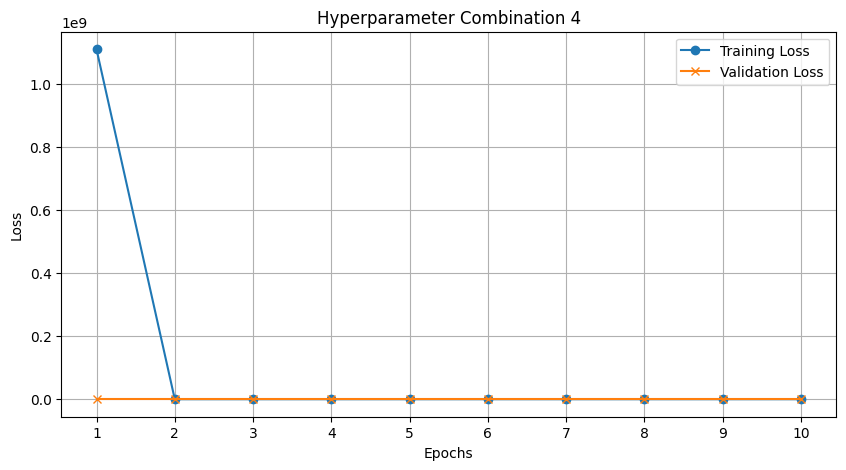

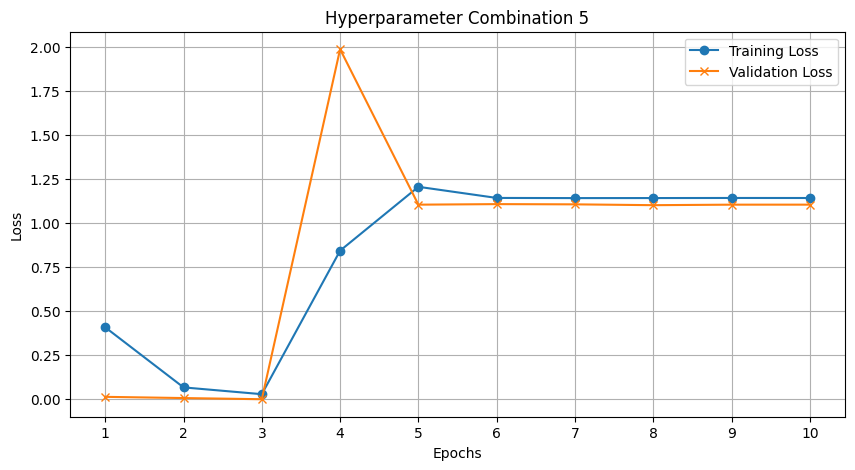

In [7]:
import matplotlib.pyplot as plt

# Define the training and validation losses for each hyperparameter combination
train_losses = [
    [1.3474, 1.1440, 1.1439, 1.1427, 1.1420, 1.1421, 1.1420, 1.1418, 1.1420, 1.1419],  # Combination 1
    [2.5253, 0.1866, 0.1536, 0.1908, 0.1054, 0.0746, 0.0580, 0.0455, 0.0419, 0.0381],  # Combination 2
    [0.5477, 0.1287, 0.0659, 0.0271, 0.0282, 0.0306, 0.0213, 0.0251, 0.0162, 0.0142],  # Combination 3
    [1109594590.9948, 0.2680, 0.1763, 0.1436, 0.1771, 0.1083, 0.0964, 0.1054, 0.0477, 0.0331],  # Combination 4
    [0.4086, 0.0680, 0.0295, 0.8435, 1.2056, 1.1425, 1.1416, 1.1418, 1.1423, 1.1421]   # Combination 5
]

val_losses = [
    [1.1018, 1.1037, 1.1046, 1.1072, 1.1047, 1.1041, 1.1031, 1.1034, 1.1053, 1.1043],  # Combination 1
    [0.1389, 0.0608, 0.0303, 0.0948, 0.0172, 0.0138, 0.0118, 0.0108, 0.0119, 0.0087],  # Combination 2
    [0.0838, 0.0077, 0.0036, 0.0007, 0.0024, 0.0007, 0.0001, 0.0008, 0.0002, 0.0038],  # Combination 3
    [0.0598, 0.5413, 0.1028, 0.1423, 0.0761, 0.0155, 0.0340, 0.0109, 0.0061, 0.0045],  # Combination 4
    [0.0144, 0.0075, 0.0009, 1.9859, 1.1043, 1.1074, 1.1061, 1.1014, 1.1043, 1.1044]   # Combination 5
]

# Define the number of epochs
epochs = range(1, 11)  # Assuming 10 epochs

# Create plots
for i in range(len(train_losses)):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses[i], label='Training Loss', marker='o')
    plt.plot(epochs, val_losses[i], label='Validation Loss', marker='x')
    
    plt.title(f'Hyperparameter Combination {i + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    
    # Save the plot to a file
    plt.savefig(f'figures/CNN_single_labeled_hyperparameter_combination_{i + 1}.png')
    
    # Show the plot
    plt.show()


### Analysis of above plots:

First 3 combinations of hypoerparameters show expected behaviour. That is consistent decrease in losses with epochs. Combination 4 shows very high 1st loss in 1st epoch and rest is almost constant(no update). Combination 5 shows a very unexpected behaviour. Initially losses are less then increase and again decrease and finally constant. Considering all these observations and least final losses combination 3 turns out to be best model. 




In [8]:
class CNNModelWithFeatureMaps(nn.Module):
    def __init__(self, task="classification", dropout_rate=0.5, num_conv_layers=2):
        super(CNNModelWithFeatureMaps, self).__init__()
        
        self.task = task
        self.feature_maps = []  # Store feature maps here
        
        # Define convolutional layers
        self.conv_layers = nn.ModuleList()
        in_channels = 1  # Starting with grayscale images
        
        for i in range(num_conv_layers):
            out_channels = 32 * (2 ** i)  # 32, 64
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            in_channels = out_channels
        
        # Define pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate the flattened size
        flattened_size = self._get_flattened_size(128, num_conv_layers)
        
        # Define fully connected layers
        self.fc_layers = nn.ModuleList([
            nn.Linear(flattened_size, 256),
            nn.Linear(256, 64)
        ])
        
        self.dropout = nn.Dropout(dropout_rate)
        
        # Output layer
        if task == "classification":
            self.output = nn.Linear(64, 4)
        else:
            self.output = nn.Linear(64, 1)
    
    def _get_flattened_size(self, input_size, num_conv_layers):
        for _ in range(num_conv_layers):
            input_size = input_size // 2
        return 32 * (2 ** (num_conv_layers - 1)) * (input_size * input_size)
    
    def forward(self, x, return_features=False):
        self.feature_maps = []  # Reset feature maps
        
        # Pass through convolutional layers with activation and pooling
        for i, conv in enumerate(self.conv_layers):
            x = conv(x)
            x = F.relu(x)
            x = self.pool(x)
            if return_features:
                self.feature_maps.append(x.detach().cpu())  # Store feature maps
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Pass through fully connected layers
        for fc in self.fc_layers:
            x = F.relu(fc(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        if return_features:
            return x, self.feature_maps
        return x

def visualize_feature_maps(model, dataloader, num_images=3, max_features_per_layer=8):
    """
    Visualize feature maps for specified number of images
    """
    model.eval()
    images_processed = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            # Get feature maps for current batch
            _, feature_maps = model(images, return_features=True)
            
            # Process each image in the batch
            for img_idx in range(min(num_images, images.size(0))):
                if images_processed >= num_images:
                    break
                    
                # Create a figure for this image
                plt.figure(figsize=(15, 5 * len(feature_maps)))
                
                # Plot original image
                plt.subplot(len(feature_maps) + 1, 1, 1)
                plt.imshow(images[img_idx][0].cpu().numpy(), cmap='gray')
                plt.title(f'Original Image (Label: {labels[img_idx]})')
                plt.axis('off')
                
                # Plot feature maps for each layer
                for layer_idx, feature_map in enumerate(feature_maps):
                    num_features = min(max_features_per_layer, feature_map.size(1))
                    
                    for feature_idx in range(num_features):
                        plt.subplot(len(feature_maps) + 1, num_features, 
                                  (layer_idx + 1) * num_features + feature_idx + 1)
                        plt.imshow(feature_map[img_idx][feature_idx].numpy(), cmap='viridis')
                        plt.title(f'Layer {layer_idx+1}, Feature {feature_idx+1}')
                        plt.axis('off')
                
                plt.tight_layout()
                plt.savefig(f'figures/feature_maps_image_{images_processed+1}.png')
                plt.show
                plt.close()
                
                images_processed += 1
            
            if images_processed >= num_images:
                break

# Train the model with best parameters
def train_best_model():
    # Initialize model with best parameters
    model = CNNModelWithFeatureMaps(
        task='classification',
        dropout_rate=0.5,
        num_conv_layers=2
    )
    
    # Initialize SGD optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    # Train the model
    criterion = nn.CrossEntropyLoss()
    num_epochs = 5
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader):.4f}')
    
    return model

# Main execution
if __name__ == "__main__":
    # Train the model
    model = train_best_model()
    
    # Visualize feature maps for 3 images
    visualize_feature_maps(model, test_loader, num_images=3, max_features_per_layer=8)
    
    print("Feature maps have been saved as PNG files.")

Epoch [1/5] Loss: 0.6649
Epoch [2/5] Loss: 0.1398
Epoch [3/5] Loss: 0.1024
Epoch [4/5] Loss: 0.0452
Epoch [5/5] Loss: 0.0190
Feature maps have been saved as PNG files.


<img src="figures/feature_maps_image_1.png" alt="feature_maps_image_1" width="600">
<img src="figures/feature_maps_image_2.png" alt="feature_maps_image_2" width="600">
<img src="figures/feature_maps_image_3.png" alt="feature_maps_image_3" width="600">

The feature maps from the two convolutional layers suggest a potential pattern of learning. In Layer 1, it seems the network might be identifying basic features such as edges and contours of the digits, as indicated by features 1-7, which look somewhat like the outlines of numbers 1, 3, and 5. The activations could resemble the original images but may emphasize different edge orientations. Moving to Layer 2, the feature maps appear to become more abstract and possibly more specialized, potentially reflecting higher-level pattern recognition. These maps might show localized activations that could correspond to specific parts of the digits, such as corners and curves, especially in features 1, 4, and 6. This progression from Layer 1 to Layer 2 suggests how CNNs might build increasingly complex representations, perhaps combining simple edge detections into more sophisticated pattern recognizers that could be useful for the digit counting task.